In [1]:
!pip3 install pandas
!pip3 install tensorflow
!pip3 install numpy
# !pip3 install codecarbon
!pip3 install scikit-learn

In [2]:
import pandas as pd
data = pd.read_csv('../../full_dataset.csv')
data.drop('date', axis=1, inplace=True)
data.head()

,production,latitude,longitude,vmp,imp,voc,isc,p_per_m2,p_max,panel_area,...,wind_speed_10m_std,wind_speed_10m_min,wind_speed_10m_q1,wind_speed_10m_q2,wind_speed_10m_q3,wind_speed_10m_max,building_id,day,month,year
0,0.8,48.575437,7.768668,27.3,7.7,33.3,8.17,143.0,210,1.72,...,0.903114,1.3,1.900,3.00,3.450,4.1,1,1,1,2019
1,16.9,48.575437,7.768668,27.3,7.7,33.3,8.17,143.0,210,1.72,...,0.969186,0.9,2.975,3.50,3.825,4.8,1,2,1,2019
2,1.4,48.575437,7.768668,27.3,7.7,33.3,8.17,143.0,210,1.72,...,0.306945,0.4,1.100,1.20,1.400,1.9,1,3,1,2019
3,6.6,48.575437,7.768668,27.3,7.7,33.3,8.17,143.0,210,1.72,...,0.491844,0.4,0.800,1.20,1.725,2.1,1,4,1,2019
4,0.3,48.575437,7.768668,27.3,7.7,33.3,8.17,143.0,210,1.72,...,0.527737,1.6,2.275,2.85,3.100,3.4,1,5,1,2019


In [3]:
data_train = data[data['building_id'] != 8]
data_test = data[data['building_id'] == 8]

data_train.shape, data_test.shape

((9617, 164), (1254, 164))

In [4]:
target_column = 'production'

x_train = data_train.drop(target_column, axis=1)
y_train = data_train[target_column].values.reshape(-1, 1)

x_test = data_test.drop(target_column, axis=1)
y_test = data_test[target_column].values.reshape(-1, 1)

In [5]:
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [6]:
x_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaler.fit(x_train)

x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

In [7]:
def get_windows(x, y, window_size):
    x_windows, y_windows = [], []

    for i in range(len(x) - window_size):
        x_window = x[i:i+window_size]
        y_window = y[i:i+window_size]

        x_window = np.hstack((x_window, y_window))

        x_windows.append(x_window)
        y_windows.append(y[i+window_size])

    return np.array(x_windows), np.array(y_windows)

In [8]:
x_train_windows, y_train_windows = get_windows(x_train_scaled, y_train, 10)
x_test_windows, y_test_windows = get_windows(x_test_scaled, y_test, 10)

In [9]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import tensorflow as tf
tf.random.set_seed(42)

2024-05-20 14:30:47.066318: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 14:30:48.054213: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
import time

params = [152, 'linear', 0.11, 240, 'tanh', 0.1, 232, 'tanh', 1, 'linear', 0.0005, 370, 112]

model = Sequential([
    LSTM(params[0], activation=params[1], input_shape=(
        x_train_windows.shape[1:]), return_sequences=True),
    Dropout(params[2]),
    LSTM(params[3], activation=params[4], return_sequences=False),
    Dropout(params[5]),
    Dense(params[6], activation=params[7]),
    Dense(params[8], activation=params[9])
])
optimizer = Adam(learning_rate=params[10])
model.compile(optimizer=optimizer, loss='mean_absolute_error')

model.summary()

def start_training():
    start_time = time.time()
    history = model.fit(x=x_train_windows,
                        y=y_train_windows,
                        epochs=params[11],
                        batch_size=params[12],
                        validation_split=0.2,
                        verbose=1,
                        shuffle=False)
    training_duration = time.time() - start_time
    return history, training_duration

2024-05-20 14:30:48.725240: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-20 14:30:48.752365: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-20 14:30:48.752867: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 152)        │       192,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 152)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 240)            │       377,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 240)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 232)            │        55,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           233 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 626,161 (2.39 MB)

 Trainable params: 626,161 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
print(params)

[152, 'linear', 0.11, 240, 'tanh', 0.1, 232, 'tanh', 1, 'linear', 0.0005, 370, 112]


In [12]:
history, training_duration = start_training()

Epoch 1/370
 1/69 ━━━━━━━━━━━━━━━━━━━━ 4:57 4s/step - loss: 23.5586

2024-05-20 14:30:53.471410: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 21.9461 - val_loss: 13.4035
Epoch 2/370
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.8305 - val_loss: 12.4683
Epoch 3/370
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 16.9762 - val_loss: 12.1629
Epoch 4/370
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 16.5454 - val_loss: 11.7490
Epoch 5/370
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 16.0167 - val_loss: 11.4236
Epoch 6/370
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 15.6119 - val_loss: 11.1991
Epoch 7/370
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 15.2779 - val_loss: 10.7851
Epoch 8/370
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 14.9016 - val_loss: 10.7565
Epoch 9/370
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 14.6529 - val_loss: 10.4330
Epoch 10/370
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 14.3834 - val_loss: 10.4974
Epoch 11/370
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 14.2358 - val_loss: 10.2347
Epoch 12/370
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s

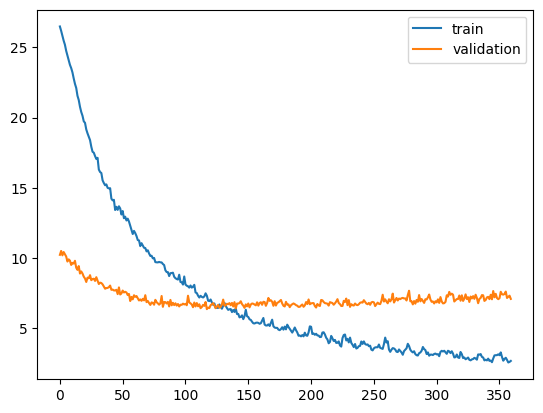

In [13]:
import matplotlib.pyplot as plt

start = 10
plt.plot(history.history['loss'][start:], label='train')
plt.plot(history.history['val_loss'][start:], label='validation')

plt.legend()
plt.show()

In [14]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [15]:
y_pred_train = model.predict(x_train_windows)
y_pred_test = model.predict(x_test_windows)

print(evaluate_model(y_train_windows, y_pred_train))
print(evaluate_model(y_test_windows, y_pred_test))

301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
{'mse': 71.9209275527138, 'r2': 0.9790275897593954, 'mae': 3.2364729684420777, 'mape': 143103067051620.34}
{'mse': 6.3168318810449575, 'r2': 0.9794789835392878, 'mae': 1.3006076935786524, 'mape': 35112386071957.39}


In [16]:
x_test_windows.shape

(1244, 10, 164)

In [17]:
baseline_predictions = []

for x in x_test_windows:
    baseline_predictions.append(x[-1][-1])

baseline_predictions = np.array(baseline_predictions).reshape(-1, 1)
print(evaluate_model(y_test_windows, baseline_predictions))

{'mse': 229.48277331189712, 'r2': 0.2544965803642203, 'mae': 10.168247588424439, 'mape': 55389931108336.664}


In [18]:
# model.save('../models/lstm_model.keras')

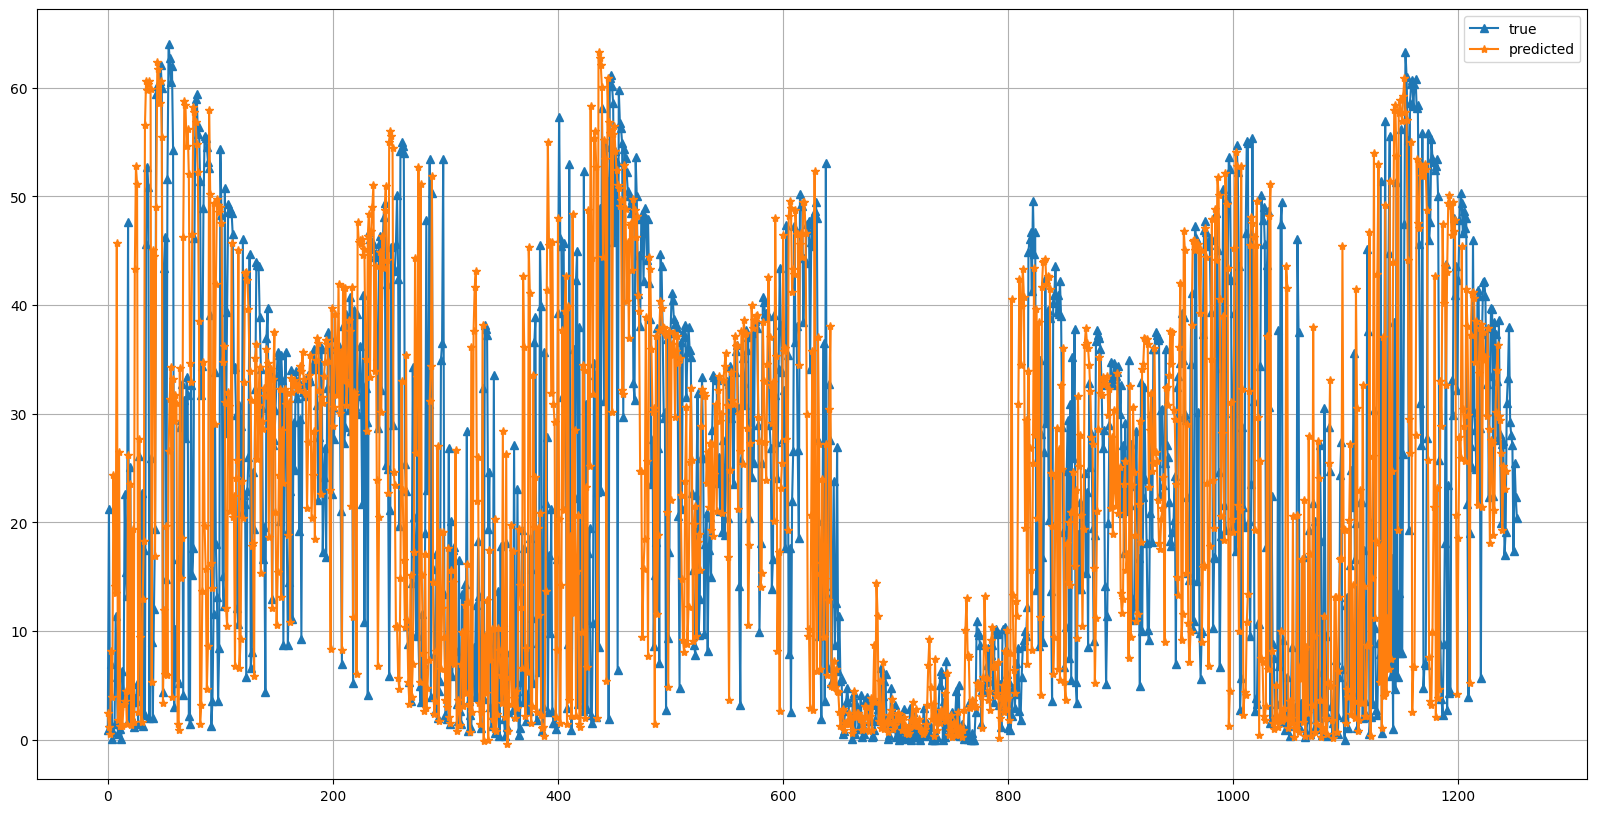

In [19]:
plt.figure(figsize=(20, 10))

start = 0
end = -1

plt.plot(y_test[start:end], '-^', label='true')
plt.plot(y_pred_test[start:end], '-*', label='predicted')

plt.legend()
plt.grid(True)
plt.show()